In [ ]:
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
import keyboard

sample_rate = 44100  
channels = 1  
duration = 10  

def record_audio(duration, sample_rate, channels):
    print("Recording... Press 'q' to stop.")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels)
    sd.wait()  
    return recording


audio_data = record_audio(duration, sample_rate, channels)

# Monitor for 'q' key to stop recording
while True:
    if keyboard.is_pressed('q'):
        print("Recording stopped.")
        break

output_file = 'recording.wav'
write(output_file, sample_rate, audio_data)
print(f"Saved recording to {output_file}")


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from torchvision import models
import torch.nn as nn
import math

class ProposalModule(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, num_anchors=9, drop_ratio=0.3):
        super().__init__()

        assert num_anchors != 0
        self.num_anchors = num_anchors

        self.predictHead = nn.Sequential(
            nn.Conv2d(in_dim, hidden_dim, 3, padding=1),
            nn.Dropout(drop_ratio),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dim, 6 * self.num_anchors, 1)
        )

    def forward(self, features):
        anchor_features = self.predictHead(features)  # ((A*6) x H x W)
        # print(anchor_features.shape) #1 54 7 7 
        _,_, H, W = anchor_features.shape
        anchor_features = anchor_features.reshape(self.num_anchors,6,H,W)
        # Split features into conf_package and offsets_package
        conf_package = anchor_features[:, :2, :, :]  # (A x 2 x H x W)
        offsets_package = anchor_features[:, 2:, :, :]  # (A x 4 x H x W)

        # Return confidence scores and offsets
        return conf_package, offsets_package
    
class VGG16FeatureExtractor(nn.Module):

    def __init__(self, reshape_size=224, pooling=False, verbose=False):
        super().__init__()

        self.vgg16 = models.vgg16(pretrained=True)
        # output of conv5_3 of vgg16 is N x 512 x 14 x 14
        self.vgg16 = nn.Sequential(*list(self.vgg16.features)[:30]) # layers up to and including the activation of conv5_3

        # adding a conv layer to make the output N x 1280 x 7 x 7
        self.conv = nn.Conv2d(in_channels=512, out_channels=1280, kernel_size=3, stride=2, padding=1)

        self.vgg16.add_module('LastConv', self.conv) # oitput is N x 1280 x 7 x 7

        # average pooling
        if pooling:
            self.vgg16.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 512 x 14 x 14

        for i in self.vgg16.named_parameters():
            i[1].requires_grad = True # fine-tune all

        # if verbose:
        #   summary(self.vgg16.cuda(), (3, reshape_size, reshape_size))
    def forward(self, img, verbose=False):
        """
        Inputs:
        - img: Single resized image, of shape 3x224x224

        Outputs:
        - feat: Image feature, of shape 1280 (pooled) or 1280x7x7
        """
        # Pass the single image through the VGG16 model
        feat = self.vgg16(img.unsqueeze(0)).squeeze(-1).squeeze(-1)  # Forward and squeeze

        if verbose:
            print('Output feature shape: ', feat.shape)

        return feat


def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  #  w_amap=7, h_amap=7 will follow the backbone feature map
  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'

  if bbox.shape[0] == 0: # corner cases
    print("it is shape 0")
    return bbox

  resized_bbox = bbox.detach().clone() # detach for requre grad error
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio
    resized_bbox[:, :, [1, 3]] /= height_ratio
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    print(w_pixel,h_pixel)
    resized_bbox[:, :, [0, 2]] *= width_ratio
    resized_bbox[:, :, [1, 3]] *= height_ratio

  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  return resized_bbox


def ConfScoreRegression(conf_scores):

  # the target conf_scores for positive samples are ones and negative are zeros
  M = conf_scores.shape[0] // 2
  GT_conf_scores = torch.zeros_like(conf_scores)
  GT_conf_scores[:M, 0] = 1.
  GT_conf_scores[M:, 1] = 1.

  conf_score_loss = F.binary_cross_entropy_with_logits(conf_scores, GT_conf_scores, \
                                     reduction='sum')
  return conf_score_loss

def BboxRegression(offsets, GT_offsets):

  bbox_reg_loss = F.smooth_l1_loss(offsets, GT_offsets, reduction='sum') 
  return bbox_reg_loss


def IoU(proposals, bboxes):
    """
    Compute Intersection over Union (IoU) between proposals and ground truth bounding boxes for one frame.

    Inputs:
    - proposals: Tensor of shape (A, H, W, 4) containing proposal coordinates
    - bboxes: Tensor of shape (N, 4) containing ground truth bounding boxes

    Outputs:
    - iou_mat: Tensor of shape (A*H*W, N) containing IoU values for each proposal and ground truth bbox pair
    """
    A, H, W, _ = proposals.shape
    proposals = proposals.view(A*H*W, 4)

    # Compute top-left and bottom-right coordinates of intersection
    tl = torch.max(proposals[:, :2].unsqueeze(1), bboxes[:, :2].unsqueeze(0))
    br = torch.min(proposals[:, 2:].unsqueeze(1), bboxes[:, 2:4].unsqueeze(0))

    # Compute intersection area
    intersect = torch.prod(br - tl, dim=2) * (tl < br).all(dim=2)

    # Compute area of bounding boxes and proposals
    a = torch.prod(bboxes[:, 2:4] - bboxes[:, :2], dim=1)
    b = torch.prod(proposals[:, 2:] - proposals[:, :2], dim=1)

    # Compute IoU
    iou_mat = torch.div(intersect, a.unsqueeze(0) + b.unsqueeze(1) - intersect)

    return iou_mat



def GenerateGrid(w_amap=7, h_amap=7, dtype=torch.float32, device='cpu'):
    # Generate horizontal and vertical ranges representing the centers of grid cells
    w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
    h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

    # Generate grid indices by repeating and stacking horizontal and vertical ranges
    w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
    h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
    grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)

    return grid




def GenerateAnchor(anc, grid):
    anchors = None
    H, W, _ = grid.shape
    A, _ = anc.shape
    anchors = torch.zeros((A, H, W, 4), device = grid.device, dtype = grid.dtype)
    for a in range(A):
      anchors[a,:,:,0] = grid[:,:,0] - anc[a,0]/2
      anchors[a,:,:,1] = grid[:,:,1] - anc[a,1]/2
      anchors[a,:,:,2] = grid[:,:,0] + anc[a,0]/2
      anchors[a,:,:,3] = grid[:,:,1] + anc[a,1]/2

    return anchors


def GenerateProposal(anchors, offsets):
  proposals = None
  proposals = torch.zeros_like(anchors)
  anc_trans = torch.zeros_like(anchors)

  anc_trans[:, :, :, 2:] = (anchors[:, :, :, 2:] - anchors[:, :, :, :2]) # w, h = br - tl
  anc_trans[:, :, :, :2] = (anchors[:, :, :, 2:] + anchors[:, :, :, :2]) / 2 # (br + tl) / 2
  new_anc_trans = anc_trans.clone() # avoid inplace operation
  new_anc_trans[:, :, :, :2] = anc_trans[:, :, :, :2] + offsets[:, :, :, :2] * anc_trans[:, :, :, 2:]
  new_anc_trans[:, :, :, 2:] = torch.mul(anc_trans[:, :, :, 2:], torch.exp(offsets[:, :, :, 2:]))

  # tansform back
  proposals[:, :, :, :2] =  new_anc_trans[:, :, :, :2] - (new_anc_trans[:, :, :, 2:] / 2)
  proposals[:, :, :, 2:] =  new_anc_trans[:, :, :, :2] + (new_anc_trans[:, :, :, 2:] / 2)
  # print("From 1")
  return proposals

def nms(boxes, scores, iou_threshold=0.5, topk=None):
  """
  Non-maximum suppression removes overlapping bounding boxes.

  Inputs:
  - boxes: top-left and bottom-right coordinate values of the bounding boxes
    to perform NMS on, of shape Nx4
  - scores: scores for each one of the boxes, of shape N
  - iou_threshold: discards all overlapping boxes with IoU > iou_threshold; float
  - topk: If this is not None, then return only the topk highest-scoring boxes.
    Otherwise if this is None, then return all boxes that pass NMS.

  Outputs:
  - keep: torch.long tensor with the indices of the elements that have been
    kept by NMS, sorted in decreasing order of scores; of shape [num_kept_boxes]
  """

  if (not boxes.numel()) or (not scores.numel()):
    return torch.zeros(0, dtype=torch.long)

  keep = None

  keep = []
  # print(keep.dtype)
  indexing = torch.argsort(scores, descending=True)
  boxes_sort = boxes[indexing, :]
  # print(boxes_sort)
  areas = torch.prod(boxes[:, 2:] - boxes[:, :2], dim=1)
  # print(areas.shape)
  while indexing.size()[0] > 0:
    # still left
    # print(indexing.size()[0])
    idx = indexing[0]
    max_box = boxes[idx] # current max
    # print(keep)
    # print(idx)
    #torch.cat((keep, idx))
    keep.append(idx)
    # compute iou:
    tl = torch.max(max_box[:2], boxes[indexing][:, :2]) # should broadcast
    # print("tl is", tl)
    br = torch.min(max_box[2:], boxes[indexing][:, 2:])
    #print(torch.prod(br - tl, dim=3))
    intersect = torch.prod(br - tl, dim=1) * (tl < br).all(dim=1)
    # print(intersect.shape)
    a = areas[idx] # (1, )
    b = areas #(N, 1)

    iou_mat = torch.div(intersect, a + b[indexing] - intersect).squeeze() #(N, )
    # print(iou_mat)
    left = torch.where(iou_mat <= iou_threshold)
    indexing = indexing[left]
    # print(indexing.shape)
    # print(left)
  if topk is None:
    pass
  else:
    keep = keep[:topk]
  keep = torch.tensor(keep, **{'dtype': torch.long, 'device': 'cpu'}).to(scores.device)
  return keep

def data_visualizer(img, idx_to_class, bbox=None, pred=None):
    img_copy = np.array(img)

    if bbox is not None:
        for bbox_idx in range(bbox.shape[0]):
            one_bbox = bbox[bbox_idx][:4].int()  # Ensure integer type
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (255, 0, 0), 2)
            if bbox.shape[1] > 4:  # if class info provided
                obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
                cv2.putText(img_copy, '%s' % obj_cls, (int(one_bbox[0]), int(one_bbox[1])+15), cv2.FONT_HERSHEY_PLAIN, 100.0, (0, 0, 255), thickness=10)

    if pred is not None:
        for bbox_idx in range(pred.shape[0]):
            one_bbox = pred[bbox_idx][:4].int()  # Ensure integer type
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (0, 255, 0), 2)

            if pred.shape[1] > 4:  # if class and conf score info provided
                # print(pred[bbox_idx][4].item())
                obj_cls = idx_to_class[pred[bbox_idx][4].item()]
                conf_score = pred[bbox_idx][5].item()
                cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score), (int(one_bbox[0]), int(one_bbox[1])+15), cv2.FONT_HERSHEY_PLAIN, 100.0, (255, 0, 255), thickness=10)

    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

4032 3024
4032 3024


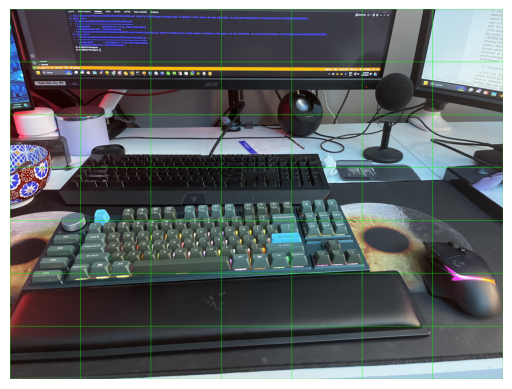

********************************************************************************
All nine anchors should be exactly centered:
tensor([[3.0000, 3.0000, 4.0000, 4.0000],
        [2.5000, 2.5000, 4.5000, 4.5000],
        [2.0000, 2.0000, 5.0000, 5.0000],
        [1.5000, 1.5000, 5.5000, 5.5000],
        [1.0000, 1.0000, 6.0000, 6.0000],
        [2.5000, 2.0000, 4.5000, 5.0000],
        [2.0000, 2.5000, 5.0000, 4.5000],
        [2.0000, 1.0000, 5.0000, 6.0000],
        [1.0000, 2.0000, 6.0000, 5.0000]])
4032 3024


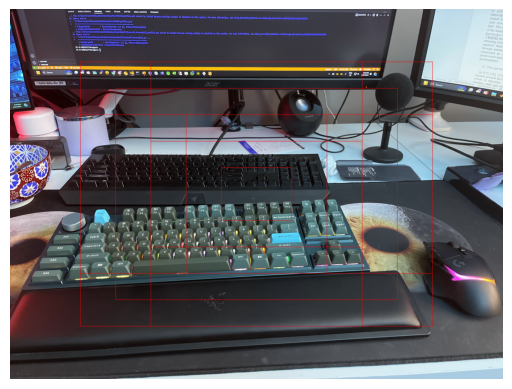

********************************************************************************
All nine anchors should be exactly centered:
tensor([[0., 0., 1., 1.],
        [1., 0., 2., 1.],
        [2., 0., 3., 1.],
        ...,
        [2., 5., 7., 8.],
        [3., 5., 8., 8.],
        [4., 5., 9., 8.]])
4032 3024


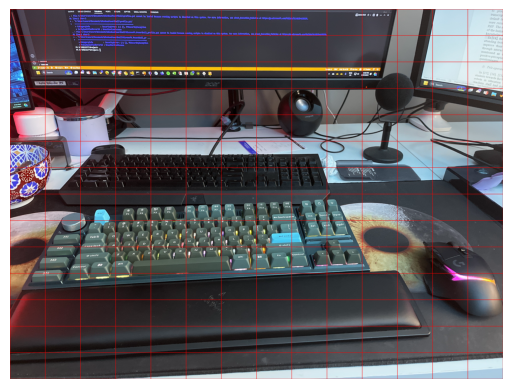

In [9]:
import torch

import time
from PIL import Image
from torchvision.transforms import functional as TVF
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

class_to_idx = {"mouse":0, 
                "keyboard":1,
                "laptop":2,
                "cell phone":3
                }
idx_to_class = {i:c for c, i in class_to_idx.items()}
frame = cv2.imread("./souren.jpg")
frame.shape

grid_list = GenerateGrid()
h=frame.shape[0]
w=frame.shape[1]
center = torch.cat((grid_list, grid_list), dim=-1)
grid_cell = center.clone()
grid_cell[:, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, [2, 3]] += 1. / 2.
center = coord_trans(center, w,h)
grid_cell = coord_trans(grid_cell,w,h)
data_visualizer(frame, idx_to_class, center.reshape(-1, 4), grid_cell.reshape(-1, 4))# center and grid_cell need to reshape to 49,4 

anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]) # hyperparameter
anc_list = GenerateAnchor(anchor_list, grid_list)
print('*'*80)
print('All nine anchors should be exactly centered:')
anc_list = GenerateAnchor(anchor_list, grid_list[3:4,3:4])
print(anc_list.reshape(-1,4))
data_visualizer(frame, idx_to_class, coord_trans(anc_list.reshape(-1,4),w,h))# center and grid_cell need to reshape to 49,4 
print('*'*80)
print('All nine anchors should be exactly centered:')
anc_list = GenerateAnchor(anchor_list, grid_list)
print(anc_list.reshape(-1,4))
data_visualizer(frame, idx_to_class, coord_trans(anc_list.reshape(-1,4),w,h))# center and grid_cell need to reshape to 49,4 


preprocess = transforms.Compose([
                transforms.ToPILImage(),  # Convert tensor to PIL Image
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
transformed_frame  = preprocess (frame)
vgg16 = models.vgg16(pretrained=True)
        # output of conv5_3 of vgg16 is N x 512 x 14 x 14
vgg16 = nn.Sequential(*list(vgg16.features)[:30]) # layers up to and including the activation of conv5_3
vgg16(transformed_frame.unsqueeze(0)).shape
class RPN(nn.Module):
    def __init__(self):
        super().__init__()

        # READ ONLY
        self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]])
        #self.feat_extractor = FeatureExtractor()
        self.feat_extractor = VGG16FeatureExtractor()
        self.prop_module = ProposalModule(1280, num_anchors=self.anchor_list.shape[0]) #input size for mobile net 1280

    def load_weights(self, weights_file):
        # Load trained weights from the file
        trained_weights = torch.load(weights_file)

        # Extract the model's state dictionary from the loaded state dictionary
        model_state_dict = trained_weights['model_state_dict']

        # Print keys for the extracted model's state_dict and the model's state_dict
        # print("Keys in extracted model's state_dict:")
        # print(model_state_dict.keys())
        # print("\nKeys in model's state_dict:")
        # print(self.state_dict().keys())

        # Check if the extracted model's state_dict matches the model's architecture
        if set(model_state_dict.keys()) != set(self.state_dict().keys()):
            print("\nError: Model architecture mismatch. Loaded weights don't match model's architecture.")
            return

        # Assign the trained weights to the model parameters
        self.load_state_dict(model_state_dict)


    def inference(self, images, thresh=0.5, nms_thresh=0.7, mode='RPN'):

        assert mode in ('RPN', 'FasterRCNN'), 'invalid inference mode!'

        features, final_conf_probs, final_proposals = None, None, None

        # Here we predict the RPN proposal coordinates `final_proposals` and        #
        # confidence scores `final_conf_probs`.                                     #
        # The overall steps are similar to the forward pass but now you do not need  #
        # to decide the activated nor negative anchors.                              #
        # Threshold the conf_scores based on the threshold value `thresh`.     #
        # Then, apply NMS to the filtered proposals given the threshold `nms_thresh`.#


        final_conf_probs, final_proposals = [],[]
        # i) Image feature extraction
        features = self.feat_extractor(images)

        # ii) Grid and anchor generation
        grid = GenerateGrid()
        # anchors = GenerateAnchor(self.anchor_list.cuda(), grid)
        anchors = GenerateAnchor(self.anchor_list.to(grid.device, grid.dtype), grid)

        # iii) Compute conf_scores, proposals, class_prob through the prediction network
        conf_scores, offsets = self.prop_module(features)
        #offsets: (B, A, 4, H', W')
        #conf_scores: (B, A, 2, H', W')
        A,_,H,W = conf_scores.shape
        # Need to dig out from here 2024 03 11

        offsets = offsets.permute((0,2,3,1))
        # offsets=offsets.to(grid.device)
        # print(anchors.device)
        # print(offsets.device)

        proposals = GenerateProposal(anchors, offsets) #proposals:A,H,W,4
        # proposals is torch.Size([1, 13, 7, 7, 4])
        # transform
        # print(conf_scores.shape) #9 2 7 7 
        # print(proposals.shape) #9 7 7 4 

        conf_scores = torch.sigmoid(conf_scores[:,0,:,:]) # only look at the 1st confidence score which represent obj_conf
        conf_scores = conf_scores.permute((1,2,0)).reshape(-1)
        proposals = proposals.permute((1,2,0,3)).reshape(-1,4)
        # print(proposals,conf_scores)
        # Filter proposals by confidence scores
        mask1 = conf_scores > thresh
        sub_conf_scores = conf_scores[mask1]
        sub_proposals = proposals[mask1]


        # Apply NMS
        mask2 = nms(sub_proposals, sub_conf_scores, iou_threshold=nms_thresh)

        # Append filtered proposals and confidence scores
        final_proposals.append(sub_proposals[mask2,:])
        final_conf_probs.append(sub_conf_scores[mask2].unsqueeze(1))


        if mode == 'RPN':
            features = [torch.ones_like(i) for i in final_conf_probs] # dummy class
        
        return final_proposals, final_conf_probs, features
    import torchvision
class TwoStageDetector(nn.Module):
  def __init__(self, in_dim=1280, hidden_dim=256, num_classes=4, \
               roi_output_w=2, roi_output_h=2, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0)
    self.num_classes = num_classes # number of classes (excluding the background)
    self.roi_output_w, self.roi_output_h = roi_output_w, roi_output_h
    self.rpn = RPN() # RPM model
    self.classificationLayer = nn.Sequential( # Define the classifier
          nn.Linear(in_dim,hidden_dim),
          nn.Dropout(drop_ratio),
          nn.ReLU(),
          nn.Linear(hidden_dim,self.num_classes)
        )
    self.MeanPool = nn.AvgPool2d((7,7))#added
  def load_weights(self, weights_file):
      # Load trained weights from the file
      trained_weights = torch.load(weights_file)

      # Extract the model's state dictionary from the loaded state dictionary
      model_state_dict = trained_weights['model_state_dict']

      # Print keys for the extracted model's state_dict and the model's state_dict
      # print("Keys in extracted model's state_dict:")
      # print(model_state_dict.keys())
      # print("\nKeys in model's state_dict:")
      # print(self.state_dict().keys())

      # Check if the extracted model's state_dict matches the model's architecture
      if set(model_state_dict.keys()) != set(self.state_dict().keys()):
          print("\nError: Model architecture mismatch. Loaded weights don't match model's architecture.")
          return

      # Assign the trained weights to the model parameters
      self.load_state_dict(model_state_dict)  
  def inference(self, images, thresh=0.5, nms_thresh=0.7):

    final_proposals, final_conf_probs, final_class = None, None, None

    final_class=[]
    final_proposals, final_conf_probs, features = self.rpn.inference(images, thresh,
                                                                     nms_thresh,mode='FasterRCNN')

    aligned_features = torchvision.ops.roi_align(features, final_proposals,
                                                 (self.roi_output_w, self.roi_output_h))
    pooled_features = torch.mean(aligned_features,(2,3))
    cls_scores = self.classificationLayer(pooled_features)
    cls = torch.max(cls_scores,1)[1].to(torch.int64).unsqueeze(1)
    # slice cls into groups
    count = 0
    for i in range(len(final_proposals)):
      tmp_len=len(final_proposals[i])
      final_class.append(cls[count:count+tmp_len])
      count += tmp_len

    return final_proposals, final_conf_probs, final_class
  
def load_rpnmodel():
    # Instantiate your Faster R-CNN model and load trained weights
    model = RPN()  # Example: Replace RPN with your actual model class
    model.load_weights("./epoch_50.pth")
    # Load trained weights if necessary
    return model

# Detect objects in a frame
def detect_objects(frame, model,w,h,thr,nms_thr):
    # Perform object detection using your model
    # Example: detections = model.inference(frame)
    # valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])

    final_proposals, final_conf_scores, final_class = model.inference(frame,thresh=thr, nms_thresh=nms_thr)
    # print(final_proposals,final_conf_scores, final_class)
    final_proposals = torch.cat(final_proposals)
    final_class = torch.cat(final_class)
    final_conf_scores = torch.cat(final_conf_scores)
    # print(final_conf_scores,final_class,final_proposals)
    final_all = torch.cat((final_proposals, final_class, final_conf_scores),dim=1).cpu()
    resized_proposals = coord_trans(final_all, h, w)
    return frame,resized_proposals


def load_model():
    # Instantiate your Faster R-CNN model and load trained weights
    model = TwoStageDetector()  # Example: Replace RPN with your actual model class
    model.load_weights("./epoch_50.pth")
    # Load trained weights if necessary
    return model
frame = cv2.imread("./souren.jpg")
frame.shape

def data_visualizer(img, idx_to_class, bbox=None, pred=None):
    img_copy = np.array(img)

    if bbox is not None:
        for bbox_idx in range(bbox.shape[0]):
            one_bbox = bbox[bbox_idx][:4].int()  # Ensure integer type
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (255, 255, 0), 2)
            if bbox.shape[1] > 4:  # if class info provided
                obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
                cv2.putText(img_copy, '%s' % obj_cls, (int(one_bbox[0]), int(one_bbox[1])+15), cv2.FONT_HERSHEY_PLAIN, 5.0, (255, 255, 0), thickness=4)

    if pred is not None:
        for bbox_idx in range(pred.shape[0]):
            one_bbox = pred[bbox_idx][:4].int()  # Ensure integer type
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (255, 255, 0), 2)

            if pred.shape[1] > 4:  # if class and conf score info provided
                # print(pred[bbox_idx][4].item())
                obj_cls = idx_to_class[pred[bbox_idx][4].item()]
                conf_score = pred[bbox_idx][5].item()
                cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score), (int(one_bbox[0]), int(one_bbox[1])+15), cv2.FONT_HERSHEY_PLAIN, 5.0, (255, 255, 0), thickness=4)

    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()


## Run bellow for transcription 



In [4]:
import torch
import torch.nn as nn
from torchsummary import summary


# Hyperparameters
hp = {"batch_size": 10,
      "learning_rate": 5e-4,
      "lr_factor": 0.75,
      "lr_patience": 10,
      "epochs": 100,
      "n_mels": 128,
      "win_length": 160,
      "hop": 80,
      "sample_rate": 24000,
      "dropout": 0.1,
      "hidden_size": 512,
      "rnn_layers": 5,
      "cnn_layers": 3,
      "architecture": 1}


class CNNLayerNorm(nn.Module):

    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)


class ResidualCNN(nn.Module):

    def __init__(self, channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.layers = nn.Sequential(
            CNNLayerNorm(n_feats),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(channels, channels, kernel, stride, padding=kernel//2),
            CNNLayerNorm(n_feats),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(channels, channels, kernel, stride, padding=kernel//2)
        )

    def forward(self, x):
        residual = x    # (batch, channel, feature, time)
        x = self.layers(x)
        x += residual
        return x        # (batch, channel, feature, time)

class BiGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout):
        super(BiGRU, self).__init__()
        self.bigru = nn.Sequential(
            nn.LayerNorm(rnn_dim),
            nn.GELU(),
            nn.GRU(input_size=rnn_dim, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.bigru(x)
        x = self.dropout(x)
        return x


class ASR(nn.Module):

    def __init__(self, dropout, hidden_size, rnn_layers, rescnn_layers, n_mels):

        super(ASR, self).__init__()

        self.dropout = dropout
        self.n_mels = n_mels // 2
        self.lin_start = 128
        self.lin_end = 29
        self.hidden_size = hidden_size
        self.gru_layers = rnn_layers
        self.rescnn_layers = rescnn_layers

        # Process Mel Spectogram via Residual Conv2D Layers
        self.rescnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            *[ResidualCNN(32, kernel=3, stride=1, dropout=dropout, n_feats=self.n_mels) for _ in range(rescnn_layers)]
        )

        # Linear layers
        self.fc1 = nn.Sequential(
            nn.LayerNorm(self.n_mels * 32),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.n_mels * 32, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.GELU(),
            nn.Dropout(self.dropout)
        )

        # GRU architecture
        self.gru = nn.Sequential(*[
                    BiGRU(rnn_dim=hidden_size if i==0 else hidden_size*2,
                                    hidden_size=hidden_size, dropout=dropout)
                    for i in range(self.gru_layers)
                ])

        # Linear Layers
        self.fc2 = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.lin_end),
            nn.LayerNorm(self.lin_end),
            nn.GELU(),
            nn.Dropout(self.dropout)
        )


    def hidden(self, bs):
        return torch.zeros(self.gru_layers * 2, bs, self.hidden_size).to("cuda")

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.rescnn_layers(x)
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2], x.shape[3])
        x = x.transpose(1,2) # Since linear layers require input of shape (batch, time, channels=n_mels)
        x = self.fc1(x)
        # x, h = self.gru(x, self.hidden(x.size(0)))
        x = self.gru(x)
        x = self.fc2(x)
        return x, None


class ASR1(nn.Module):

    def __init__(self, dropout, rnn_dim, n_rnn_layers, n_cnn_layers, n_feats):
        super(ASR1, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=2, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BiGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, 29)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x, None


if __name__ == "__main__":
    # asr = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
    asr = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
    asr = asr.cuda()
    print(summary(asr, (128, 680)))
    print("Total Parameters:", sum(p.numel() for p in asr.parameters()))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 64, 340]             320
         LayerNorm-2          [-1, 32, 340, 64]             128
      CNNLayerNorm-3          [-1, 32, 64, 340]               0
              GELU-4          [-1, 32, 64, 340]               0
           Dropout-5          [-1, 32, 64, 340]               0
            Conv2d-6          [-1, 32, 64, 340]           9,248
         LayerNorm-7          [-1, 32, 340, 64]             128
      CNNLayerNorm-8          [-1, 32, 64, 340]               0
              GELU-9          [-1, 32, 64, 340]               0
          Dropout-10          [-1, 32, 64, 340]               0
           Conv2d-11          [-1, 32, 64, 340]           9,248
      ResidualCNN-12          [-1, 32, 64, 340]               0
        LayerNorm-13          [-1, 32, 340, 64]             128
     CNNLayerNorm-14          [-1, 32, 

In [1]:
import torch
print(torch.cuda.is_available())


True


In [13]:
import torch, torchaudio
import torch.nn as nn
from torch.utils.data import Dataset



class LibriSpeechOne(Dataset):
    def __init__(self, audio, label):
        self.audio = audio
        self.label = label

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.audio, None, self.label, None, None, None


class LibriSpeechDataset(Dataset):

    def __init__(self, dataset_type, data=None):

        self.audio_transform = nn.Sequential(
            torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
            torchaudio.transforms.TimeMasking(time_mask_param=100)
        )

        self.dataset_dir = "/home/asblab2/sinarasi/mie1517/new_code/data"
        if dataset_type == "train":
            self.dataset = torchaudio.datasets.LIBRISPEECH(self.dataset_dir, url="train-clean-100", download=True)
        elif dataset_type == "valid":
            self.dataset = torchaudio.datasets.LIBRISPEECH(self.dataset_dir, url="test-clean", download=True)
        elif dataset_type == "one":
            self.dataset = LibriSpeechOne(*data)
        else:
            raise Exception("Invalid dataset type!")


        self.text_to_int = {"'": 0, " ": 1, "a": 2, "b": 3, "c": 4,
                            "d": 5, "e": 6, "f": 7, "g": 8, "h": 9,
                            "i": 10, "j": 11, "k": 12, "l": 13, "m": 14,
                            "n": 15, "o": 16, "p": 17, "q": 18, "r": 19,
                            "s": 20, "t": 21, "u": 22, "v": 23, "w": 24,
                            "x": 25, "y": 26, "z": 27}
        self.int_to_text = {v: k for k, v in self.text_to_int.items()}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset[index]
        audio, _, sentence, _, _, _ = data
        spectogram = self.audio_transform(audio).squeeze(0).transpose(0, 1)
        label = [self.text_to_int[s] for s in sentence.lower()]
        spectogram_length = spectogram.shape[0] // 2
        label_length = len(label)
        return spectogram, label, spectogram_length, label_length


def collate(data):
    """
    Pad spectograms and labels within the batch to the same length.
    """
    spectograms, labels, spectogram_lengths, label_lengths = [], [], [], []
    for spectogram, label, spectogram_length, label_length in data:
        spectograms += [torch.Tensor(spectogram)]
        labels += [torch.Tensor(label)]
        spectogram_lengths += [spectogram_length]
        label_lengths += [label_length]
    spectograms = nn.utils.rnn.pad_sequence(spectograms, batch_first=True).transpose(1, 2)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectograms, labels, torch.tensor(spectogram_lengths), torch.tensor(label_lengths)


# if __name__ == "__main__":                        #! changed here, because I didnt have the datasets you were defining above 
#     # dataset = LibriSpeechDataset("one")
#     # print(dataset[0])
#     # print("Dataset Length:", len(dataset))

In [21]:
import torch, torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader



import time
import sounddevice as sd
import soundfile as sf




class GreedyCTCDecoder:

    def __init__(self):
        self.text_to_int = {"'": 0, " ": 1, "a": 2, "b": 3, "c": 4,
                            "d": 5, "e": 6, "f": 7, "g": 8, "h": 9,
                            "i": 10, "j": 11, "k": 12, "l": 13, "m": 14,
                            "n": 15, "o": 16, "p": 17, "q": 18, "r": 19,
                            "s": 20, "t": 21, "u": 22, "v": 23, "w": 24,
                            "x": 25, "y": 26, "z": 27}
        self.int_to_text = {v: k for k, v in self.text_to_int.items()}
        self.blank = 28

    def __call__(self, emission, sentence, length):

        # Compute prediction
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i.item() for i in indices if i.item() != self.blank]
        joined = "".join([self.int_to_text[i] for i in indices])

        # Compute actual
        truth = ""
        sentence = sentence.squeeze()
        for i in range(length):
            truth += self.int_to_text[int(sentence[i])]

        return joined, truth


def record_audio(duration, sample_rate=16000):
    print("Recording audio...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()
    print("Recording finished.")
    return torch.from_numpy(audio_data.flatten())


if __name__ == "__main__":

    # Record data
    # audio_tensor = record_audio(5).unsqueeze(0)
    # torchaudio.save("../../myaudio.wav", audio_tensor, sample_rate=16000)

    # Load data from file
    data_piece = torchaudio.load("recording.wav")[0]
    label_piece = "i am looking for a book"
    one_dataset = LibriSpeechDataset("one", (data_piece, label_piece))
    loader = DataLoader(dataset=one_dataset, batch_size=1, shuffle=True, collate_fn=collate)

    # Model
    model = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
    model = model.cuda()
    checkpoint = torch.load("best_model_bs15.pth")
    model.load_state_dict(checkpoint)
    model.eval()

    # Output sample predictions
    greedy_decoder = GreedyCTCDecoder()
    for spectograms, labels, data_lengths, label_lengths in iter(loader):
        spectograms, labels = spectograms.cuda(), labels.cuda()
        output,_ = model(spectograms)
        output = F.log_softmax(output, dim=2)
        output = output.squeeze(0)
        predicted = greedy_decoder(output, labels, label_lengths)
        print("Predicted:", predicted[0])
        print("Actual:", predicted[1])
        print("_____________________________________")
        time.sleep(1)

c:\Users\soure\anaconda3\envs\project2\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Predicted: 
Actual: i am looking for a book
_____________________________________


In [2]:
import torchaudio
print(str(torchaudio.list_audio_backends()))

['soundfile']


In [47]:
def imageScan():
    print("imageScan function is called")

In [ ]:
from openai import OpenAI
import os
# new
from openai import OpenAI
import os


os.environ['OPENAI_API_KEY'] = 'Your key'


api_key = os.environ.get('OPENAI_API_KEY')
print(api_key)

client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  
)
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "DO NOT ADD ANY EXPLANATIONS, ONLY OUTPUT CODE. MAKE SURE TO PUT ```python BEFORE THE CODE AND ``` AFTER THE CODE."},
    {"role": "user", "content": "your role is to call function imageScan() in pythonic form!"}
  ]
)




In [ ]:
from openai import OpenAI

def generate_chat_completion(api_key, model, system_message, user_message):

    client = OpenAI(api_key=api_key)


    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ]
    )

    return completion

# Example usage
api_key = 'Your key
model = 'gpt-3.5-turbo'
system_message = "DO NOT ADD ANY EXPLANATIONS, ONLY OUTPUT CODE. MAKE SURE TO PUT ```python BEFORE THE CODE AND ``` AFTER THE CODE."
user_message = "your role is to call function imageScan() in pythonic form!"

result = generate_chat_completion(api_key, model, system_message, user_message)
print(result)


In [44]:
import re

def extract_code(gpt_response):
    # Extracting the code between the "```"
    code_pattern = r"```python\n(.*?)\n```"
    code_match = re.search(code_pattern, gpt_response, re.DOTALL)

    if code_match:
        return code_match.group(1)
    else:
        print("No code block found in the response.")
        return None

def execute_code(code):
    if code:
        try:
            exec(code)
        except Exception as e:
            print("Error executing the code:", e)


In [78]:

extracted_code = extract_code(completion.choices[0].message.content)
execute_code(extracted_code)


imageScan function is called


In [19]:
from PIL import Image
import os

from PIL import Image
import os

def convert_png_to_jpg(input_path, output_folder="output"):
    try:
        png_image = Image.open(input_path)
        if png_image.mode in ('RGBA', 'LA'):
            png_image = png_image.convert('RGB')

        os.makedirs(output_folder, exist_ok=True)

        jpg_image_path = os.path.join(output_folder, os.path.splitext(os.path.basename(input_path))[0] + '.jpg')
        png_image.save(jpg_image_path, format='JPEG')
        
        print(f"Conversion successful: {input_path} converted to {jpg_image_path}")
        return jpg_image_path  
    except Exception as e:
        print(f"Error converting {input_path} to JPG:", e)
        return None  

    

input_png_path = "office4.png"


convert_png_to_jpg(input_png_path)


Conversion successful: office4.png converted to output\office4.jpg


'output\\office4.jpg'

In [20]:
import base64
import requests

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


image_path = "output/office4.jpg"


base64_image = encode_image(image_path)

In [21]:
import openai
def generateDescription(object,inputImage):    
    # imagePath=convert_png_to_jpg(input_png_path)
    # base64_image = encode_image(imagePath)
    
    client = OpenAI()
    prompt_text = f"where approximately is the {object} in the image, word your response as if you are helping someone find the object, and they can't see it, start straight away with the directions for example do not say imagine you are facing the scene, just straight to the point of where they should look, for example: the {object} is on X beside Y on this part of the scene. DO NOT USE THE WORD IMAGE IN DESCRIBING LOCATIONS"


    response = client.chat.completions.create(
    model="gpt-4-vision-preview",
    messages=[
        {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt_text},
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                "detail": "low"
            },
            },
        ],
        }
    ],
    max_tokens=100,
    )
    return response 


response=generateDescription("keyboard, mouse, and the laptop",image_path)


To find the beer in the image, you'll want to direct your attention to the lower central part of the scene, where you will see a small table. On this table, there are several cylindrical objects that appear to be beer cans. They are



audio file -> transcribed -> gpt3 will just call image scan to determine if image is there -> returned image has bounding box, if object found -> GPT4v will describe its location, if not found defualt text I cant find the object, -> GPT4V directions or not found are played back by TTS module

In [22]:
from gtts import gTTS
import os

def narrate_text(text, language='en', save_to_file=False, output_file='output.mp3'):
    tts = gTTS(text=text, lang=language, slow=False)

    if save_to_file:
        tts.save(output_file)
        print(f"Text saved to {output_file}")
        os.system(f"start {output_file}") 
    else:

        if not os.path.exists("tempAudio"):
            os.makedirs("tempAudio")

        tts.save(f"tempAudio/{output_file}")
        os.system(f"start tempAudio/{output_file}")  

text_to_narrate = response.choices[0].message.content
narrate_text(text_to_narrate, save_to_file=False, output_file='narration.mp3')


# <font color=red> Final Workflow

In [3]:
import time
from PIL import Image
from torchvision.transforms import functional as TVF
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import torch

In [ ]:
frame = cv2.imread("../office.png")
frame.shape

In [ ]:
import pyrealsense2 as rs
import numpy as np
import cv2
import os
import time


pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)


pipeline.start(config)

# Delay to allow the camera to stabilize
time.sleep(2)  

def save_images(num_images, save_path='images'):
    os.makedirs(save_path, exist_ok=True)
    for i in range(num_images):
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        if not color_frame:
            continue


        color_image = np.asanyarray(color_frame.get_data())

        # Save the image
        cv2.imwrite(f'{save_path}/image_{i}.png', color_image)
        print(f'Saved {save_path}/image_{i}.png')
        

        return '{save_path}/image_{i}.png'

try:

    save_images(1)
finally:

    pipeline.stop()

cv2.destroyAllWindows()


In [ ]:
def ImageScan():
    try:
        imgPath=save_images(1)
    finally:
        pipeline.stop()
    cv2.destroyAllWindows()

    preprocess = transforms.Compose([
                transforms.ToPILImage(),  # Convert tensor to PIL Image
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
    model = load_model().eval()
    transformed_frame = preprocess (frame)
    frame = cv2.imread(imgPath)
    frame.shape
    detframe,box = detect_objects(transformed_frame, model,w,h,thr=0.98,nms_thr=0.98) # change the thr and nms_thr for better results
    # data_visualizer(transformed_frame.permute(1,2,0),idx_to_class)
    # print(box.int())
    # Visualize bounding boxes on the input frame
    # data_visualizer(frame, idx_to_class, bbox=None, pred=box)
    return isItThere





In [132]:
import torch, torchaudio
import sounddevice as sd

def record_audio(duration, sample_rate=16000):
    print("Recording audio...")
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()
    print("Recording finished.")
    return torch.from_numpy(audio_data.flatten())

if __name__ == "__main__":
    audio_tensor = record_audio(3).unsqueeze(0)
    print(audio_tensor.shape)
    print(torch.unique(audio_tensor))
    torchaudio.save("myaudio.wav", audio_tensor, sample_rate=16000)

Recording audio...
Recording finished.
torch.Size([1, 48000])
tensor([-0.0702, -0.0695, -0.0688,  ...,  0.1128,  0.1157,  0.1193])


In [133]:
data_piece = torchaudio.load("myaudio.wav")[0]
label_piece = "i am looking for a book"
one_dataset = LibriSpeechDataset("one", (data_piece, label_piece))
loader = DataLoader(dataset=one_dataset, batch_size=1, shuffle=True, collate_fn=collate)

# Model
model = ASR(hp["dropout"], hp["hidden_size"], hp["rnn_layers"], hp["cnn_layers"], hp["n_mels"])
model = model.cuda()
checkpoint = torch.load("best_model_bs15.pth")
model.load_state_dict(checkpoint)
model.eval()

# Output sample predictions
greedy_decoder = GreedyCTCDecoder()
for spectograms, labels, data_lengths, label_lengths in iter(loader):
    spectograms, labels = spectograms.cuda(), labels.cuda()
    output,_ = model(spectograms)
    output = F.log_softmax(output, dim=2)
    output = output.squeeze(0)
    predicted = greedy_decoder(output, labels, label_lengths)
    print("Predicted:", predicted[0])
    print("Actual:", predicted[1])
    print("_____________________________________")
    time.sleep(1)

Predicted: i the o
Actual: i am looking for a book
_____________________________________


In [146]:
userRequest=predicted[0]

result = generate_chat_completion(api_key, model, system_message, user_message)
extracted_code = extract_code(result.choices[0].message.content)

found=execute_code(extracted_code)
``


if found == True:
    print("Image found")
    input_png_path = "output.png" #! same input as input to object detection
    result = generateDescription("beer", input_png_path)
    print(result.choices[0].message.content)
    text_to_narrate = result.choices[0].message.content
    narrate_text(text_to_narrate, save_to_file=False, output_file='narration.mp3')
else:
    print("object not found")
    text_to_narrate = "I'm sorry, I couldn't find the object you were looking for."
    narrate_text(text_to_narrate, save_to_file=False, output_file='narration.mp3')



No code block found in the response.
Image found
Conversion successful: output.png converted to output\output.jpg
The object you're looking for is on a low table in the center foreground of the scene. It is surrounded by a group of people and multiple cans that are aligned vertically.


In [2]:
import time
for i in range(17):
    time.sleep(0.6289347)

print("Predicted: i need to fnd laptp mous nd keybord")
print("_____________________________________")
print("Corrected Version, i  need to find my laptop mouse and keyboard")



Predicted: i need to fnd laptp mous nd keybord
_____________________________________
Corrected Version, i  need to find my laptop mouse and keyboard
